In [1]:
from pathlib import Path
import yaml
import os 
os.chdir(Path('/gpfs-calypso/home/globc/garcia/'))
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings

from matplotlib import transforms
from ClimateBench.funcs.settings import PREDICTIONS_DIR, CONFIGS_DIR
from utils.plotutils import EvaluationPlots



/softs/Anaconda/2024.02-1/envs/gloenv_py3.11/lib/python3.12/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
exp = 'exp1'
simu = "1pctCO2"
variables = ['tas', 'pr']
proj = ccrs.Mollweide() 
save_path = '/scratch/globc/garcia/ClimateBench/graphs/exp1/nb_figs/'
with open(CONFIGS_DIR / 'config_plots.yaml') as file:
    config_plots = yaml.safe_load(file)   

In [3]:
list = []
for v in variables:
    da = xr.concat(
        [xr.open_dataarray(PREDICTIONS_DIR /exp /simu/ f"{simu}_010_150_lstm_5scenarios_{v}_paper{i}.nc") for i in range(5)],
        pd.Index(np.arange(5), name="member"),
        coords="all",
        )
    list.append({v: da})
nn_predictions_Reproducedv2 = xr.merge(list)
nn_predictions_Reproducedv2 = nn_predictions_Reproducedv2.rename({'longitude':'lon', 'latitude':'lat'}).transpose('lat', 'lon', 'time', 'member')

nn_predictions_Reproducedv2

<xarray.Dataset> Size: 156MB
Dimensions:  (lat: 96, lon: 144, time: 141, member: 5)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) int64 1kB 10 11 12 13 14 15 16 ... 145 146 147 148 149 150
  * member   (member) int64 40B 0 1 2 3 4
Data variables:
    tas      (lat, lon, time, member) float64 78MB 0.1303 0.08088 ... 4.795
    pr       (lat, lon, time, member) float64 78MB -0.001652 0.01217 ... 0.0645

In [21]:
data_path = '/scratch/globc/garcia/ClimateBench/rawdata/train_val/'
X = xr.open_dataset( data_path + f'inputs_{simu}.nc')
Y = xr.open_dataset(data_path + f'outputs_{simu}.nc').sel(time=slice(10, None))

print(Y.tas.values.shape)
print(nn_predictions_Reproducedv2.tas.values.shape)

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400
Y

(1, 141, 96, 144)
(96, 144, 141, 5)


<xarray.Dataset> Size: 39MB
Dimensions:                    (lat: 96, lon: 144, time: 141, member: 1)
Coordinates:
  * lat                        (lat) float64 768B -90.0 -88.11 ... 88.11 90.0
  * lon                        (lon) float64 1kB 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 1kB 10 11 12 13 ... 147 148 149 150
    quantile                   float64 8B ...
  * member                     (member) int64 8B 1
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 8MB ...
    tas                        (member, time, lat, lon) float32 8MB -0.4156 ....
    pr                         (member, time, lat, lon) float32 8MB -0.000663...
    pr90                       (member, time, lat, lon) float64 16MB -0.04235...

In [22]:
models = [nn_predictions_Reproducedv2.mean('member'), Y.mean('member')]
colors = ['darkorange', 'mediumpurple']
model_labels = ["Neural Network Reproduced v2", 'NorESM2']
labels = ["Temperature (K)", "Precipitation (mm/day)"]
kwargs = [{"cmap":"coolwarm", "vmax":6}, {"cmap":"BrBG", "vmin":-4, "vmax":4}]


In [23]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

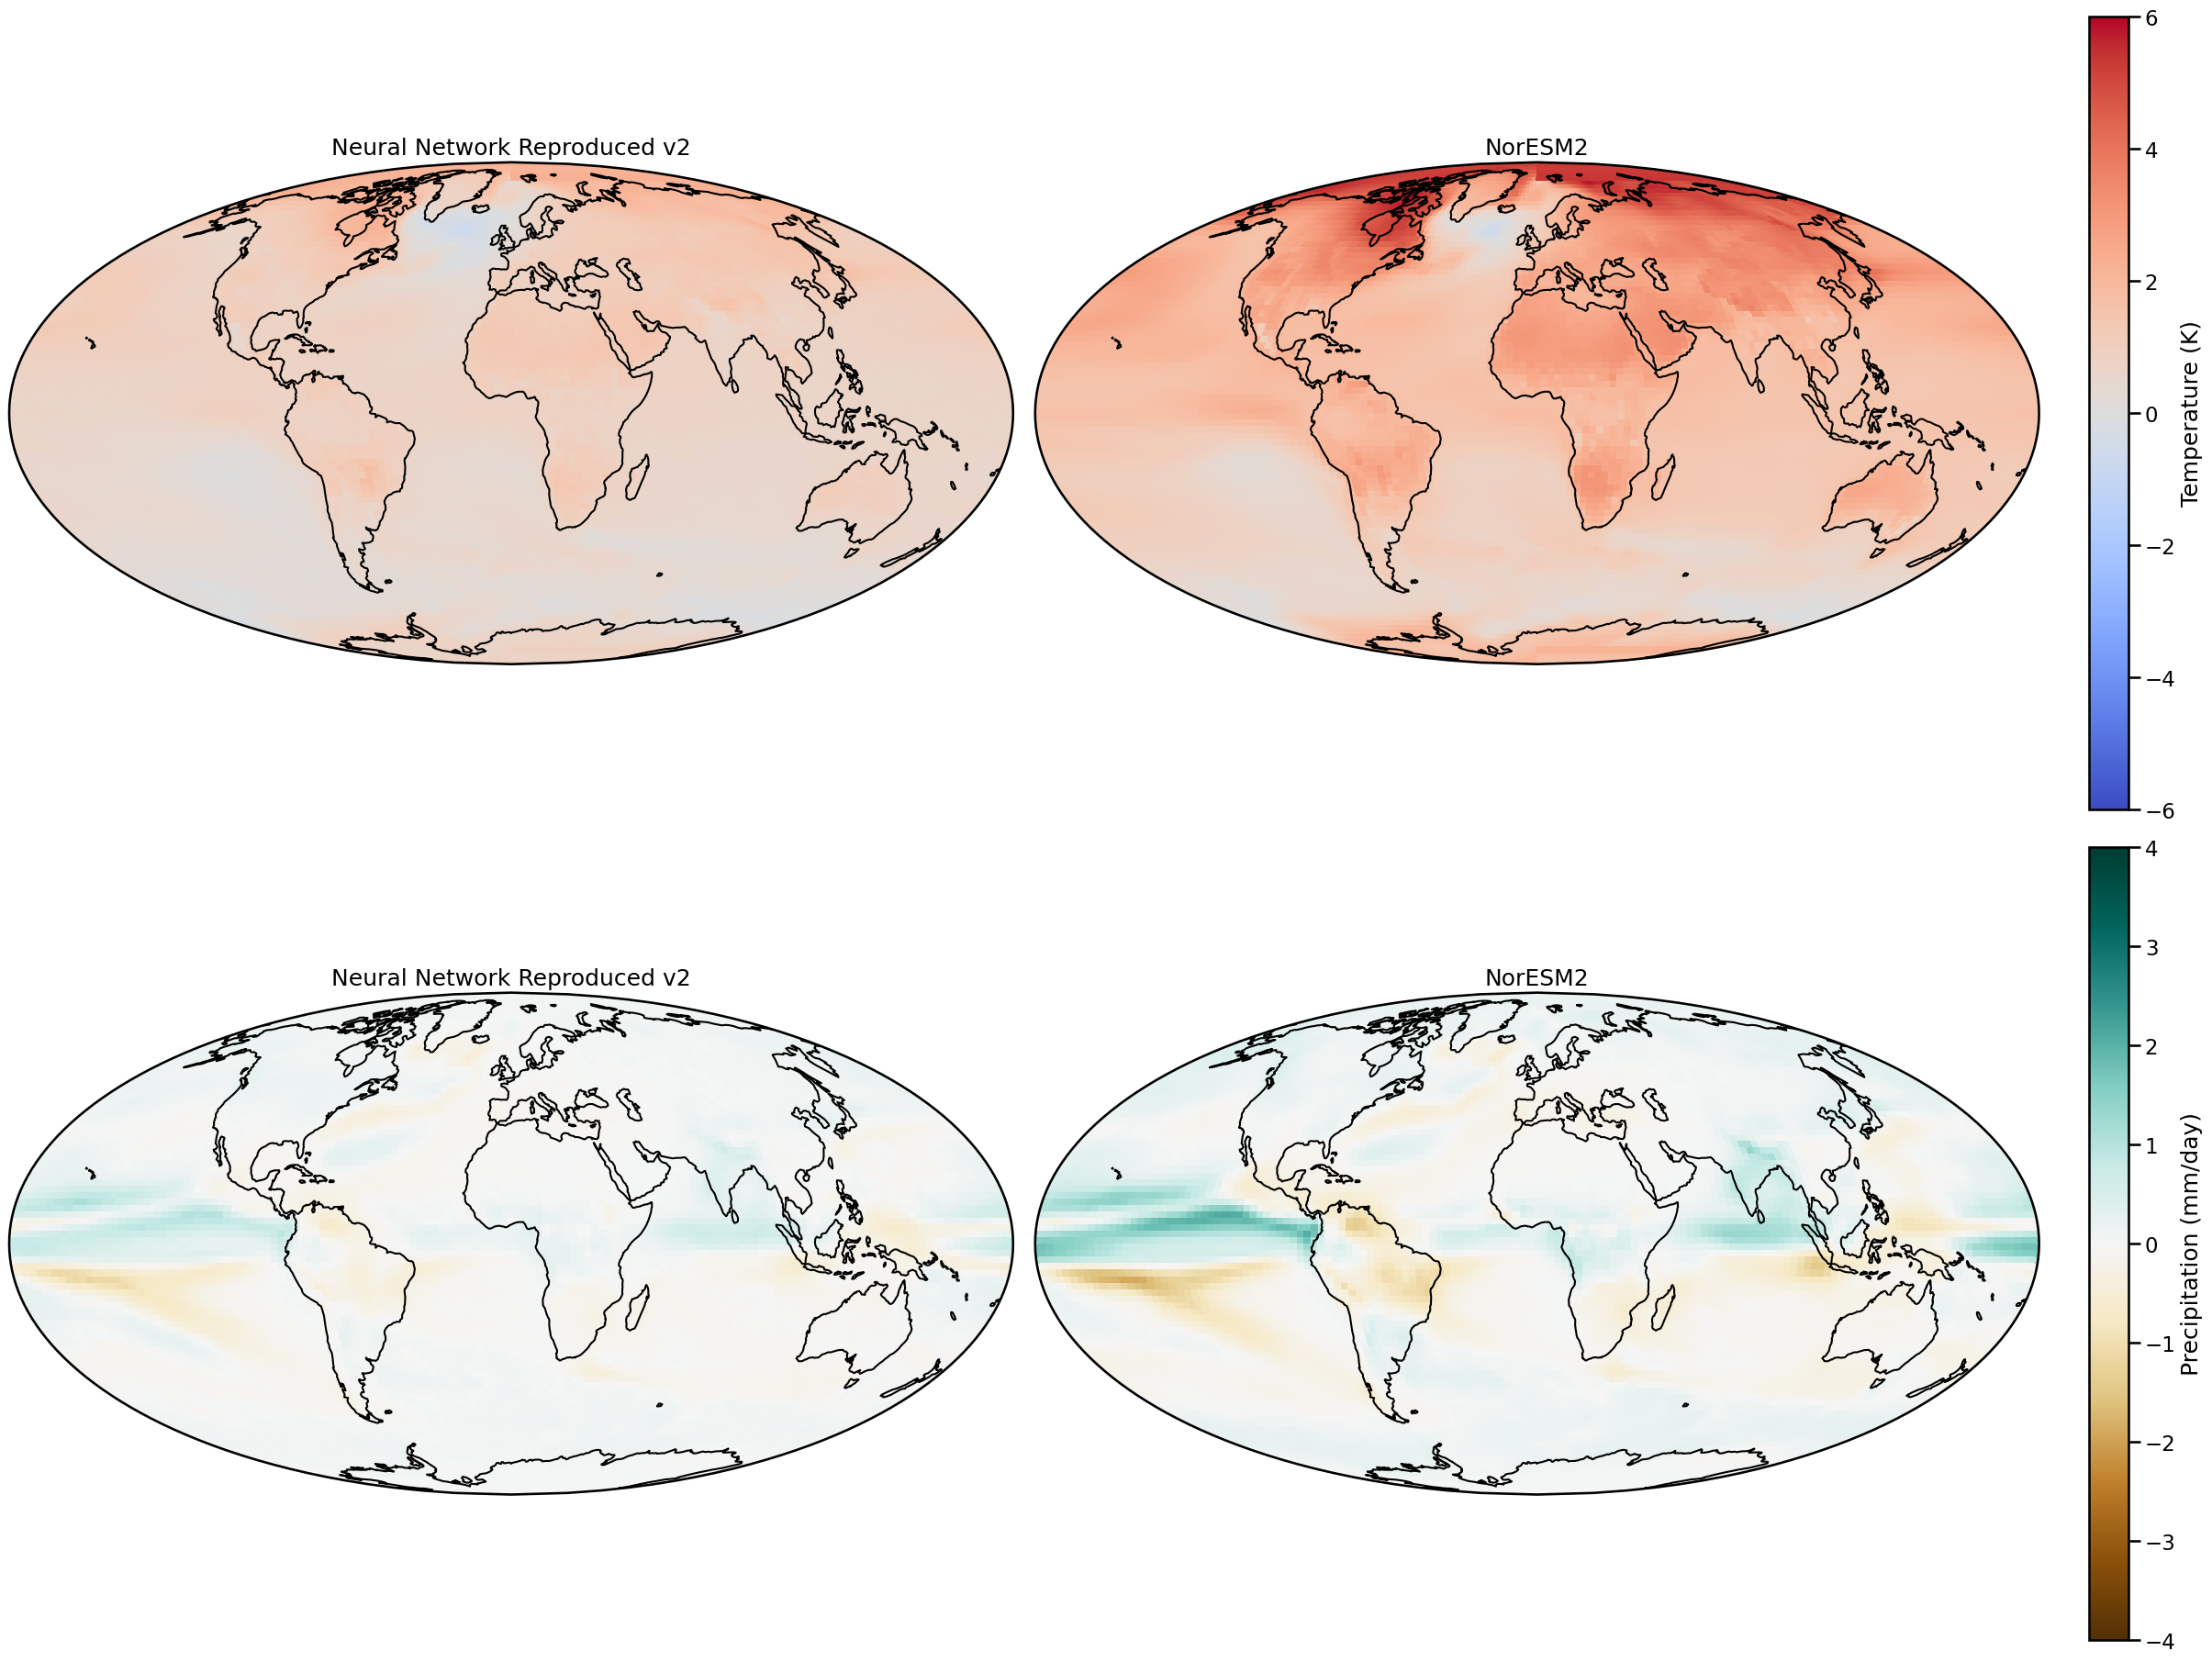

In [24]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(2, 2, subplot_kw={'projection':proj}, figsize=(24, 18), constrained_layout=True)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models, model_labels):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
    plt.savefig(save_path + f'{simu}_time_mean.png')

In [25]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

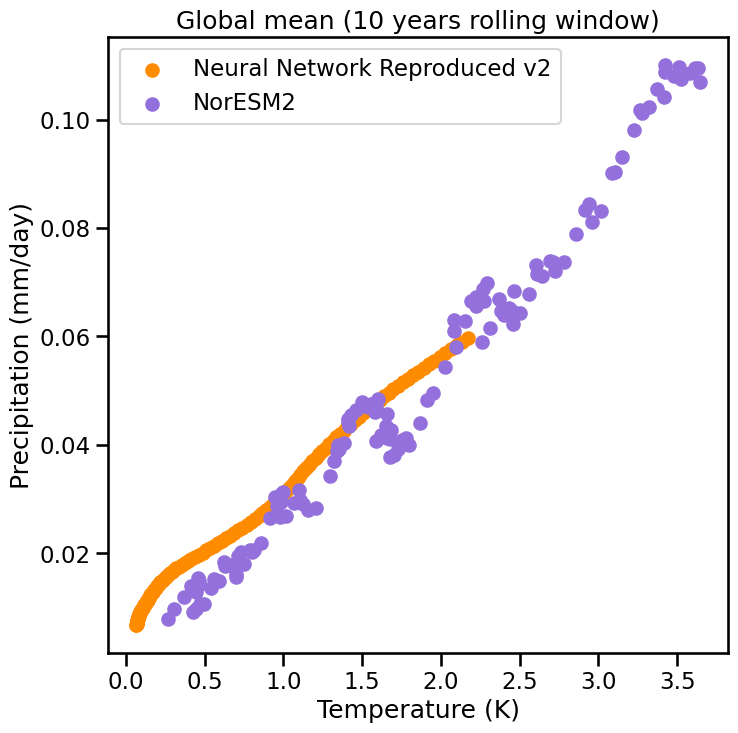

In [26]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label, color in zip(models, model_labels, colors):
        ax.scatter(global_mean(model['tas']).rolling(time=10, center=True).mean(), 
                   global_mean(model['pr']).rolling(time=10, center=True).mean(), 
                   label=model_label,
                  color=color)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

    plt.title('Global mean (10 years rolling window)')
    plt.savefig(save_path + f'{simu}_global_mean_tas_pr.png')

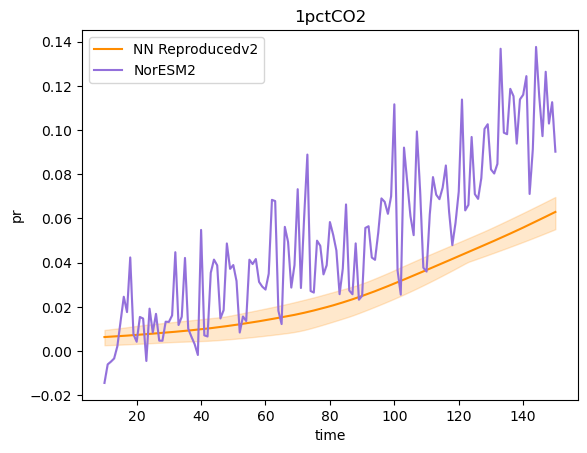

In [27]:
global_mean(nn_predictions_Reproducedv2['pr']).mean('member').plot(label='NN Reproducedv2', color='darkorange')
plt.fill_between(nn_predictions_Reproducedv2['time'].values,
                        global_mean(nn_predictions_Reproducedv2['pr']).values.min(axis=1),
                        global_mean(nn_predictions_Reproducedv2['pr']).values.max(axis=1),
                        alpha=0.2, color="darkorange")


plt.fill_between(Y['time'].values,
                        global_mean(Y['pr']).values.min(axis=0),
                        global_mean(Y['pr']).values.max(axis=0),
                        alpha=0.1, color="mediumpurple")
global_mean(Y['pr'].mean('member')).plot(label='NorESM2', color=colors[1])
plt.legend()
plt.title(simu)
plt.savefig(save_path + f'{simu}_spatial_mean_pr.png')


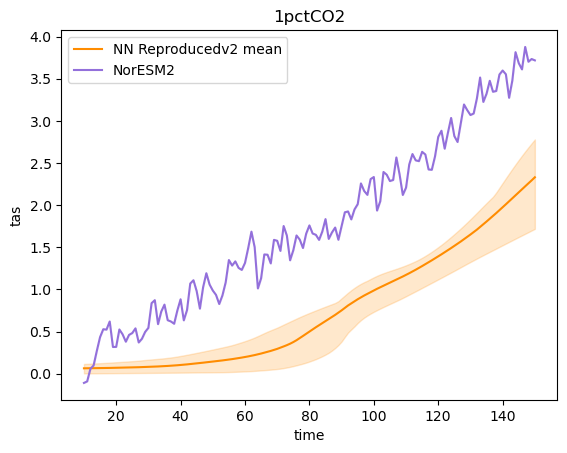

In [28]:
global_mean(nn_predictions_Reproducedv2['tas']).mean('member').plot(label='NN Reproducedv2 mean', color='darkorange')

plt.fill_between(nn_predictions_Reproducedv2['time'].values,
                        global_mean(nn_predictions_Reproducedv2['tas']).values.min(axis=1),
                        global_mean(nn_predictions_Reproducedv2['tas']).values.max(axis=1),
                        alpha=0.2, color="darkorange")
plt.fill_between(Y['time'].values,
                        global_mean(Y['tas']).values.min(axis=0),
                        global_mean(Y['tas']).values.max(axis=0),
                        alpha=0.1, color="mediumpurple")
global_mean(Y['tas'].mean('member')).plot(label='NorESM2', color=colors[1])
plt.title(simu)
plt.legend()

plt.savefig(save_path + f'{simu}_spatial_mean_tas.png')

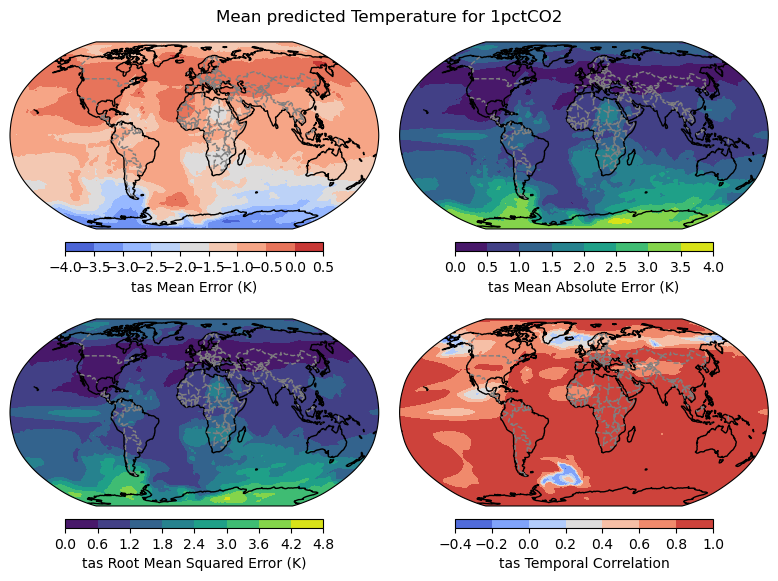

In [31]:
plot_func = EvaluationPlots(simu,
                           'tas',
                           config_plots=config_plots['outputs']['tas'])

plot_func.plot_error_maps(Y['tas'].mean('member').transpose('time', 'lat', 'lon').values,
                          nn_predictions_Reproducedv2['tas'].mean('member').transpose('time', 'lat', 'lon').values,
                          title= f'Mean predicted Temperature for {simu}', 
                          save_path=save_path + f'{simu}_error_maps_tas.png',
                            no_limits=True)

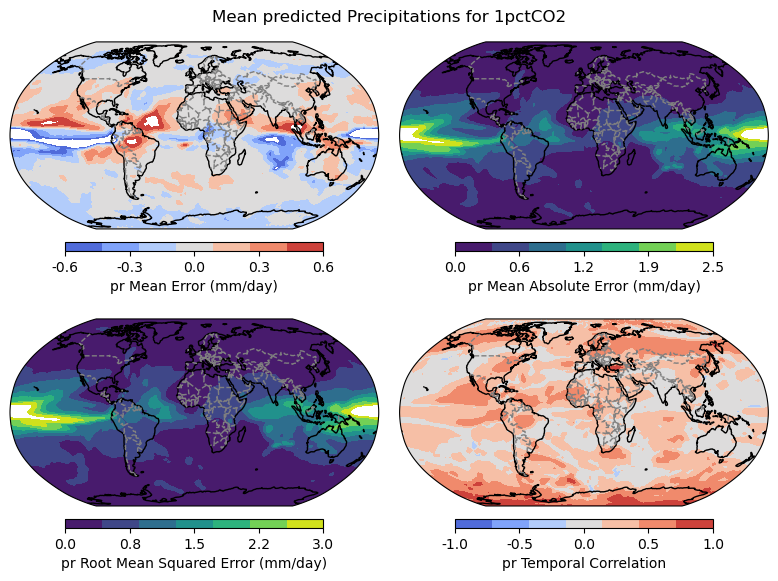

In [30]:
plot_func = EvaluationPlots(simu,
                           'pr',
                           config_plots=config_plots['outputs']['pr'])

plot_func.plot_error_maps(Y['pr'].mean('member').transpose('time', 'lat', 'lon').values,
                          nn_predictions_Reproducedv2['pr'].mean('member').transpose('time', 'lat', 'lon').values,
                          title= f'Mean predicted Precipitations for {simu}',
                          save_path=save_path + f'{simu}_error_maps_pr.png',
                            no_limits=True)

In [57]:
R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(Y.mean('member')[variable])), 
                                global_mean(model[variable])).data/ np.abs(global_mean(Y.mean('member')[variable].mean('time')).data) for variable in variables} 
#                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                           for label, model in zip(model_labels[:-1], models[:-1])
})
R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,tas,diurnal_temperature_range,pr,pr90
Neural Network Reproduced,0.0690,0.8930,0.2130,0.3280
Neural Network Reproduced v2,0.0650,0.8960,0.1910,0.3110


In [58]:
NRMSE = pd.DataFrame({
    label: {variable: rmse(Y.mean('member')[variable].mean('time'), 
                               model[variable].mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
})

NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,tas,diurnal_temperature_range,pr,pr90
Neural Network Reproduced,0.1030,8.2990,2.2310,2.6940
Neural Network Reproduced v2,0.0930,8.2100,2.1240,2.6420


In [59]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,tas,diurnal_temperature_range,pr,pr90
Neural Network Reproduced,0.4450,12.7660,3.2950,4.3350
Neural Network Reproduced v2,0.4190,12.6890,3.0770,4.1960


In [60]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]


In [61]:
combined_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

In [62]:
R2E = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None))).std().data / np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
})

NRMSE = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None)).mean('time').std('member')).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables}
})

variability_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]


In [63]:
#CMIP6_df = variability_df.copy().rename(dict(Variability='CMIP6'))
#CMIP6_df.T['CMIP6'] = np.NaN

In [64]:
# add value by hand
R2E = pd.DataFrame({
    "Neural Network" : {'tas': 0.044 , 'diurnal_temperature_range': 1.372, 'pr':0.209, 'pr90':0.346}})
NRMSE = pd.DataFrame({
    "Neural Network" : {'tas': 0.107 , 'diurnal_temperature_range': 9.917, 'pr':2.128, 'pr90':2.610}})
nn_paper_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]
nn_paper_df

R2E = pd.DataFrame({
    "CMIP6" : {'tas': 0.177 , 'diurnal_temperature_range': 0.799, 'pr':0.389, 'pr90':None}})
NRMSE = pd.DataFrame({
    "CMIP6" : {'tas': 0.258 , 'diurnal_temperature_range': 1.962, 'pr':1.994, 'pr90':None}})
CMIP6_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]
CMIP6_df

tas               diurnal_temperature_range                    pr  \
      Spatial Global  Total                   Spatial Global  Total Spatial   
CMIP6   0.258  0.177  1.143                     1.962  0.799  5.957   1.994   

                       pr90               
      Global  Total Spatial Global Total  
CMIP6  0.389  3.939     NaN    NaN   NaN

In [65]:
all_df = pd.concat([combined_df, nn_paper_df, variability_df, CMIP6_df])
all_df
all_df.style.highlight_min(axis = 0, props='font-weight: bold').format("{:.3f}")